# Notebook for the fitting Urban scaling laws in COVID-19 datasets

- Repository: [https://github.com/edugalt/scaling](https://github.com/edugalt/scaling)

- Reference: J. C. Leitao, J.M. Miotto, M. Gerlach, and E. G. Altmann, "Is this scaling nonlinear?", Royal Society Open Science 3, 150649 (2016) [DOI: 10.1098/rsos.150649](http://rsos.royalsocietypublishing.org/content/3/7/150649).

- Remove results from folder "_results" to ensure original computations (instead of reading from stored results)

In [1]:
import pandas as pd
import sys
import numpy as np
import pickle

sys.path.append("../src/")
sys.path.append("../data/")

import analysis as a
MIN_VALUE = 10**-8

%load_ext autoreload
%autoreload 2

%matplotlib inline
def summary(func):
    print(func.description,'\t Dataset:',func.dataset)
    print('Beta +- error:\t',func.beta)
    print('P-value:\t',func.p_value)
    print('BIC:\t\t',func.bic,'\n')

## Choose the dataset 

- by setting the variable dataset="name"

- Pick one of the available datasets (write 'help' as the name of the dataset for a list)

- Or, add your csv dataset to the appropriate folder:

-- New dataset with three columns (name,x,y) = (city-name, population, observable) to folder new_dataset/

-- New dataset with two columns (x,y) = (population, observable) to folder new_dataset2/

In [2]:
dataset="covid19_USA"
#Available datasets
#covid19_NSW, covid19_USA, covid19_brazil, covid19_chile

try:
    x=a.xy(dataset).x
    y=a.xy(dataset).y
except:
    print("Invalid Dataset Chosen. Available datasets are:\n")
    for i in a.DATABASES:
        print(i)
        
with open('_generated_files/x_'+dataset+'.pickle', 'wb') as handle:
        pickle.dump(x, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
with open('_generated_files/y_'+dataset+'.pickle', 'wb') as handle:
        pickle.dump(y, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
#Deleting all calculations for previously load new datasets
if dataset.startswith("new_dataset"):
    %rm _results/*new_dataset*
    
if dataset.startswith("covid19"):
    %rm _results/*covid19*

zsh:1: no matches found: _results/*covid19*


# Performing Analysis

 - Each line is one of the models, with specific constrains. Further constrains cna be fixed in each model.
 
 - This can take some time (at least a couple of minutes)

 - Increase the "required_successes=" parameter to increase precision (and computational time) 

## Log-Normal

In [3]:
ln = a.LogNormalAnalysis(dataset, required_successes=2)

## Population

In [4]:
Pop=a.PopulationAnalysis(dataset,required_successes=2)

In [5]:
ln_beta1=a.LogNormalFixedBetaAnalysis(dataset,required_successes=2)

In [6]:
ln_deltaf=a.LogNormalFixedDAnalysis(dataset,required_successes=2)

##  Gaussian

In [7]:
Gauss=a.ConstrainedDAnalysis(dataset,required_successes=2)

In [8]:
Gauss_beta1=a.ConstrainedDFixedBetaAnalysis(dataset,required_successes=2)

## Least Square Fit

In [9]:
LS=a.mls_best_fit(np.log(x),np.log(y))

In [10]:
Pop2=a.PopulationFixedGammaAnalysis(dataset,required_successes=2)

# Outcome of the Analysis 

### Printing the outcomes

In [11]:
summary(ln)
summary(ln_beta1)
summary(ln_deltaf)
summary(Gauss)
summary(Gauss_beta1)
summary(Pop)
summary(Pop2)

print("\n Least Square fitting:",LS)

Log normal fluctuations with a general \delta 	 Dataset: covid19_USA
Beta +- error:	 (0.9783959486091397, 0.007415037956039412)
P-value:	 8.37797701870301e-169
BIC:		 52992.55950082888 

Log normal fluctuations with \beta = 1 	 Dataset: covid19_USA
Beta +- error:	 (1.0, 0.0)
P-value:	 1.9735974678391218e-170
BIC:		 53018.32999156467 

Log normal fluctuations with \delta = 1 	 Dataset: covid19_USA
Beta +- error:	 (0.9934498056354987, 0.008595774079255715)
P-value:	 1.2082519024330244e-199
BIC:		 53052.69034794117 

Gaussian fluctuations with free \delta 	 Dataset: covid19_USA
Beta +- error:	 (0.9804124868119504, 0.007460645596486763)
P-value:	 6.677468611869653e-80
BIC:		 52552.362920584026 

Gaussian fluctuations with \beta = 1 and free \delta 	 Dataset: covid19_USA
Beta +- error:	 (1.0, 0.0)
P-value:	 4.4972890356095995e-90
BIC:		 52585.419786586535 

People model with free \delta 	 Dataset: covid19_USA
Beta +- error:	 (0.9852555465449745, 0.02065066104736895)
P-value:	 0.0
BIC:		 117

In [12]:
#To save the results of persons' model and LS
functions = {'Pop':Pop}
results = {}
for name, func in functions.items():

    results[name] = {'Description':func.description, 
                     'Beta +- error': func.beta,
                     'P-value': func.p_value,
                     'BIC': func.bic ,
                     'params': func.params}
results['LS'] = LS
    
with open('_generated_files/results_'+dataset+'.pickle', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Plotting data 

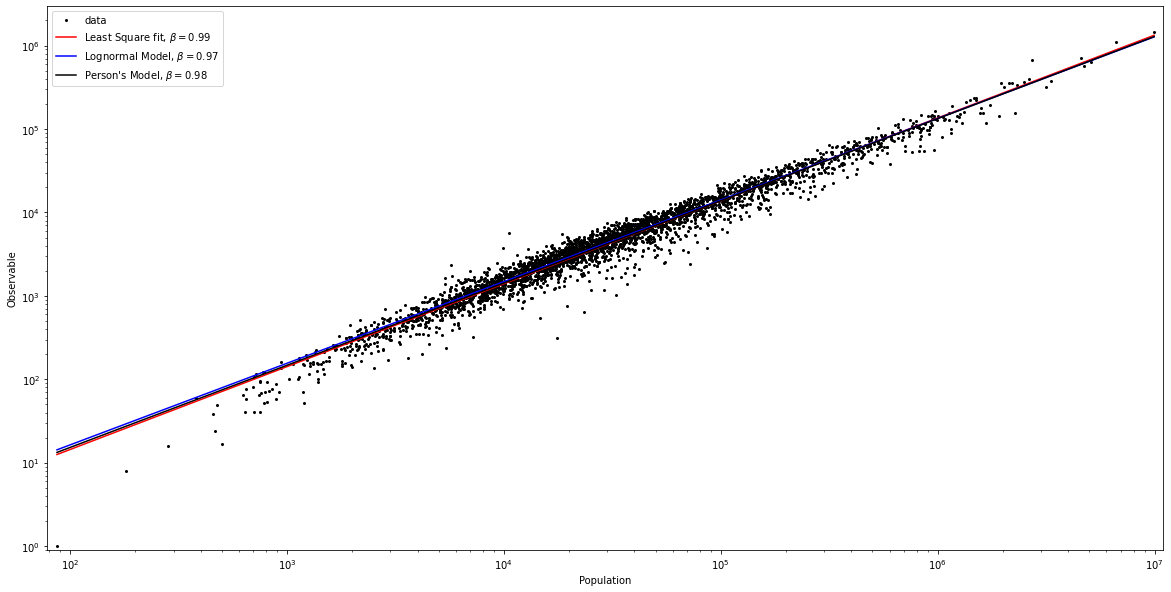

In [13]:
from matplotlib.pyplot import *
figure(figsize=(20,10))
xscale("log")
yscale("log")
xlim(0.9*min(x),1.1*max(x))
ylim(0.9*min(y),2*max(y))
plot(x, y, "o", ms=2,color="black",label="data")
plot(x, np.exp(LS[2])*x**LS[0], "-", ms=2,color="red",label=r"Least Square fit, $\beta=$"+str(LS[0])[:4])
plot(x, ln.params[0]*x**ln.params[1], "-", ms=2,color="blue",label=r"Lognormal Model, $\beta=$"+str(ln.params[1])[:4])
# People's model
Y=np.sum(y)
betaP=Pop.params[0]
Z=np.sum(np.power(x,betaP))
plot(x, Y*x**betaP/Z, "-", ms=2,color="black",label=r"Person's Model, $\beta=$"+str(betaP)[:4])
xlabel("Population")
ylabel("Observable")
legend(loc=0)
show()